In [5]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
from typing import List, Dict, Tuple, Optional
import logging

# Machine learning and similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import scipy.sparse as sp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ All libraries imported successfully")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

✅ All libraries imported successfully
📊 Pandas version: 2.2.2
🔢 NumPy version: 2.0.2


In [10]:
class DataLoader:

    def __init__(self):
        self.users_df = None
        self.posts_df = None
        self.engagements_df = None

    def load_users(self, filepath: str = 'Users.csv') -> pd.DataFrame:

        try:
            self.users_df = pd.read_csv(filepath)
            logger.info(f"Loaded {len(self.users_df)} users from {filepath}")

            # Validate required columns
            required_cols = ['user_id', 'age', 'gender', 'top_3_interests', 'past_engagement_score']
            missing_cols = [col for col in required_cols if col not in self.users_df.columns]
            if missing_cols:
                raise ValueError(f"Missing required columns in users data: {missing_cols}")

            # Check for missing values
            missing_values = self.users_df.isnull().sum()
            if missing_values.any():
                logger.warning(f"Missing values found in users data:\n{missing_values[missing_values > 0]}")

            # Validate data types and ranges
            if not self.users_df['age'].between(0, 120).all():
                logger.warning("Some age values are outside expected range (0-120)")

            if not self.users_df['past_engagement_score'].between(0, 1).all():
                logger.warning("Some engagement scores are outside expected range (0-1)")

            return self.users_df

        except Exception as e:
            logger.error(f"Error loading users data: {str(e)}")
            raise

    def load_posts(self, filepath: str = 'Posts.csv') -> pd.DataFrame:

        try:
            self.posts_df = pd.read_csv(filepath)
            logger.info(f"Loaded {len(self.posts_df)} posts from {filepath}")

            # Validate required columns
            required_cols = ['post_id', 'creator_id', 'content_type', 'tags']
            missing_cols = [col for col in required_cols if col not in self.posts_df.columns]
            if missing_cols:
                raise ValueError(f"Missing required columns in posts data: {missing_cols}")

            # Check for missing values
            missing_values = self.posts_df.isnull().sum()
            if missing_values.any():
                logger.warning(f"Missing values found in posts data:\n{missing_values[missing_values > 0]}")

            # Validate content types
            valid_content_types = ['video', 'image', 'text', 'audio']
            invalid_types = self.posts_df[~self.posts_df['content_type'].isin(valid_content_types)]
            if not invalid_types.empty:
                logger.warning(f"Found {len(invalid_types)} posts with invalid content types")

            return self.posts_df

        except Exception as e:
            logger.error(f"Error loading posts data: {str(e)}")
            raise

    def load_engagements(self, filepath: str = 'Engagements.csv') -> pd.DataFrame:

        try:
            self.engagements_df = pd.read_csv(filepath)
            logger.info(f"Loaded {len(self.engagements_df)} engagement records from {filepath}")

            # Validate required columns
            required_cols = ['user_id', 'post_id', 'engagement']
            missing_cols = [col for col in required_cols if col not in self.engagements_df.columns]
            if missing_cols:
                raise ValueError(f"Missing required columns in engagements data: {missing_cols}")

            # Check for missing values
            missing_values = self.engagements_df.isnull().sum()
            if missing_values.any():
                logger.warning(f"Missing values found in engagements data:\n{missing_values[missing_values > 0]}")

            # Validate engagement values (should be 0 or 1)
            if not self.engagements_df['engagement'].isin([0, 1]).all():
                logger.warning("Some engagement values are not 0 or 1")

            return self.engagements_df

        except Exception as e:
            logger.error(f"Error loading engagements data: {str(e)}")
            raise

    def validate_data(self) -> Dict[str, bool]:

        validation_results = {}

        if self.users_df is None or self.posts_df is None or self.engagements_df is None:
            logger.error("All datasets must be loaded before validation")
            return {'all_loaded': False}

        # Check referential integrity
        users_in_engagements = set(self.engagements_df['user_id'].unique())
        users_in_users = set(self.users_df['user_id'].unique())
        validation_results['users_integrity'] = users_in_engagements.issubset(users_in_users)

        posts_in_engagements = set(self.engagements_df['post_id'].unique())
        posts_in_posts = set(self.posts_df['post_id'].unique())
        validation_results['posts_integrity'] = posts_in_engagements.issubset(posts_in_posts)

        creators_in_posts = set(self.posts_df['creator_id'].unique())
        validation_results['creators_integrity'] = creators_in_posts.issubset(users_in_users)

        # Check for duplicates
        validation_results['users_unique'] = not self.users_df['user_id'].duplicated().any()
        validation_results['posts_unique'] = not self.posts_df['post_id'].duplicated().any()

        # Log validation results
        for check, passed in validation_results.items():
            status = "✅ PASSED" if passed else "❌ FAILED"
            logger.info(f"{check}: {status}")

        return validation_results

    def get_data_summary(self) -> Dict[str, any]:

        summary = {}

        if self.users_df is not None:
            summary['users'] = {
                'count': len(self.users_df),
                'age_range': (self.users_df['age'].min(), self.users_df['age'].max()),
                'gender_distribution': self.users_df['gender'].value_counts().to_dict(),
                'avg_engagement_score': self.users_df['past_engagement_score'].mean()
            }

        if self.posts_df is not None:
            summary['posts'] = {
                'count': len(self.posts_df),
                'content_type_distribution': self.posts_df['content_type'].value_counts().to_dict(),
                'unique_creators': self.posts_df['creator_id'].nunique()
            }

        if self.engagements_df is not None:
            summary['engagements'] = {
                'total_interactions': len(self.engagements_df),
                'positive_engagements': (self.engagements_df['engagement'] == 1).sum(),
                'engagement_rate': self.engagements_df['engagement'].mean(),
                'users_with_engagements': self.engagements_df['user_id'].nunique(),
                'posts_with_engagements': self.engagements_df['post_id'].nunique()
            }

        return summary

print("✅ DataLoader class defined successfully")

✅ DataLoader class defined successfully


In [11]:
# Initialize data loader and load all datasets
data_loader = DataLoader()

print("📂 Loading datasets...")
users_df = data_loader.load_users()
posts_df = data_loader.load_posts()
engagements_df = data_loader.load_engagements()

print("\n🔍 Validating data integrity...")
validation_results = data_loader.validate_data()

print("\n📊 Data Summary:")
summary = data_loader.get_data_summary()
for dataset, stats in summary.items():
    print(f"\n{dataset.upper()}:")
    for key, value in stats.items():
        print(f"  {key}: {value}")

📂 Loading datasets...

🔍 Validating data integrity...

📊 Data Summary:

USERS:
  count: 50
  age_range: (18, 34)
  gender_distribution: {'M': 25, 'F': 23, 'Other': 2}
  avg_engagement_score: 0.5878

POSTS:
  count: 100
  content_type_distribution: {'image': 37, 'video': 31, 'text': 20, 'audio': 12}
  unique_creators: 43

ENGAGEMENTS:
  total_interactions: 1000
  positive_engagements: 497
  engagement_rate: 0.497
  users_with_engagements: 50
  posts_with_engagements: 100


In [12]:
# Display sample data from each dataset
print("👥 USERS DATA (first 5 rows):")
display(users_df.head())

print("\n📝 POSTS DATA (first 5 rows):")
display(posts_df.head())

print("\n💬 ENGAGEMENTS DATA (first 10 rows):")
display(engagements_df.head(10))

👥 USERS DATA (first 5 rows):


,user_id,age,gender,top_3_interests,past_engagement_score
0,U1,24,F,"sports, art, gaming",0.61
1,U2,32,F,"travel, food, fashion",0.93
2,U3,28,Other,"sports, travel, fashion",0.40
3,U4,25,M,"fashion, music, tech",0.53
4,U5,24,M,"fashion, food, fitness",0.80



📝 POSTS DATA (first 5 rows):


,post_id,creator_id,content_type,tags
0,P1,U44,video,"sports, food"
1,P2,U26,video,"music, travel"
2,P3,U32,text,"sports, travel"
3,P4,U6,image,"music, gaming"
4,P5,U32,image,"food, fashion"



💬 ENGAGEMENTS DATA (first 10 rows):


,user_id,post_id,engagement
0,U1,P52,1
1,U1,P44,0
2,U1,P1,1
3,U1,P4,1
4,U1,P65,0
5,U1,P32,1
6,U1,P39,0
7,U1,P33,0
8,U1,P38,1
9,U1,P61,0


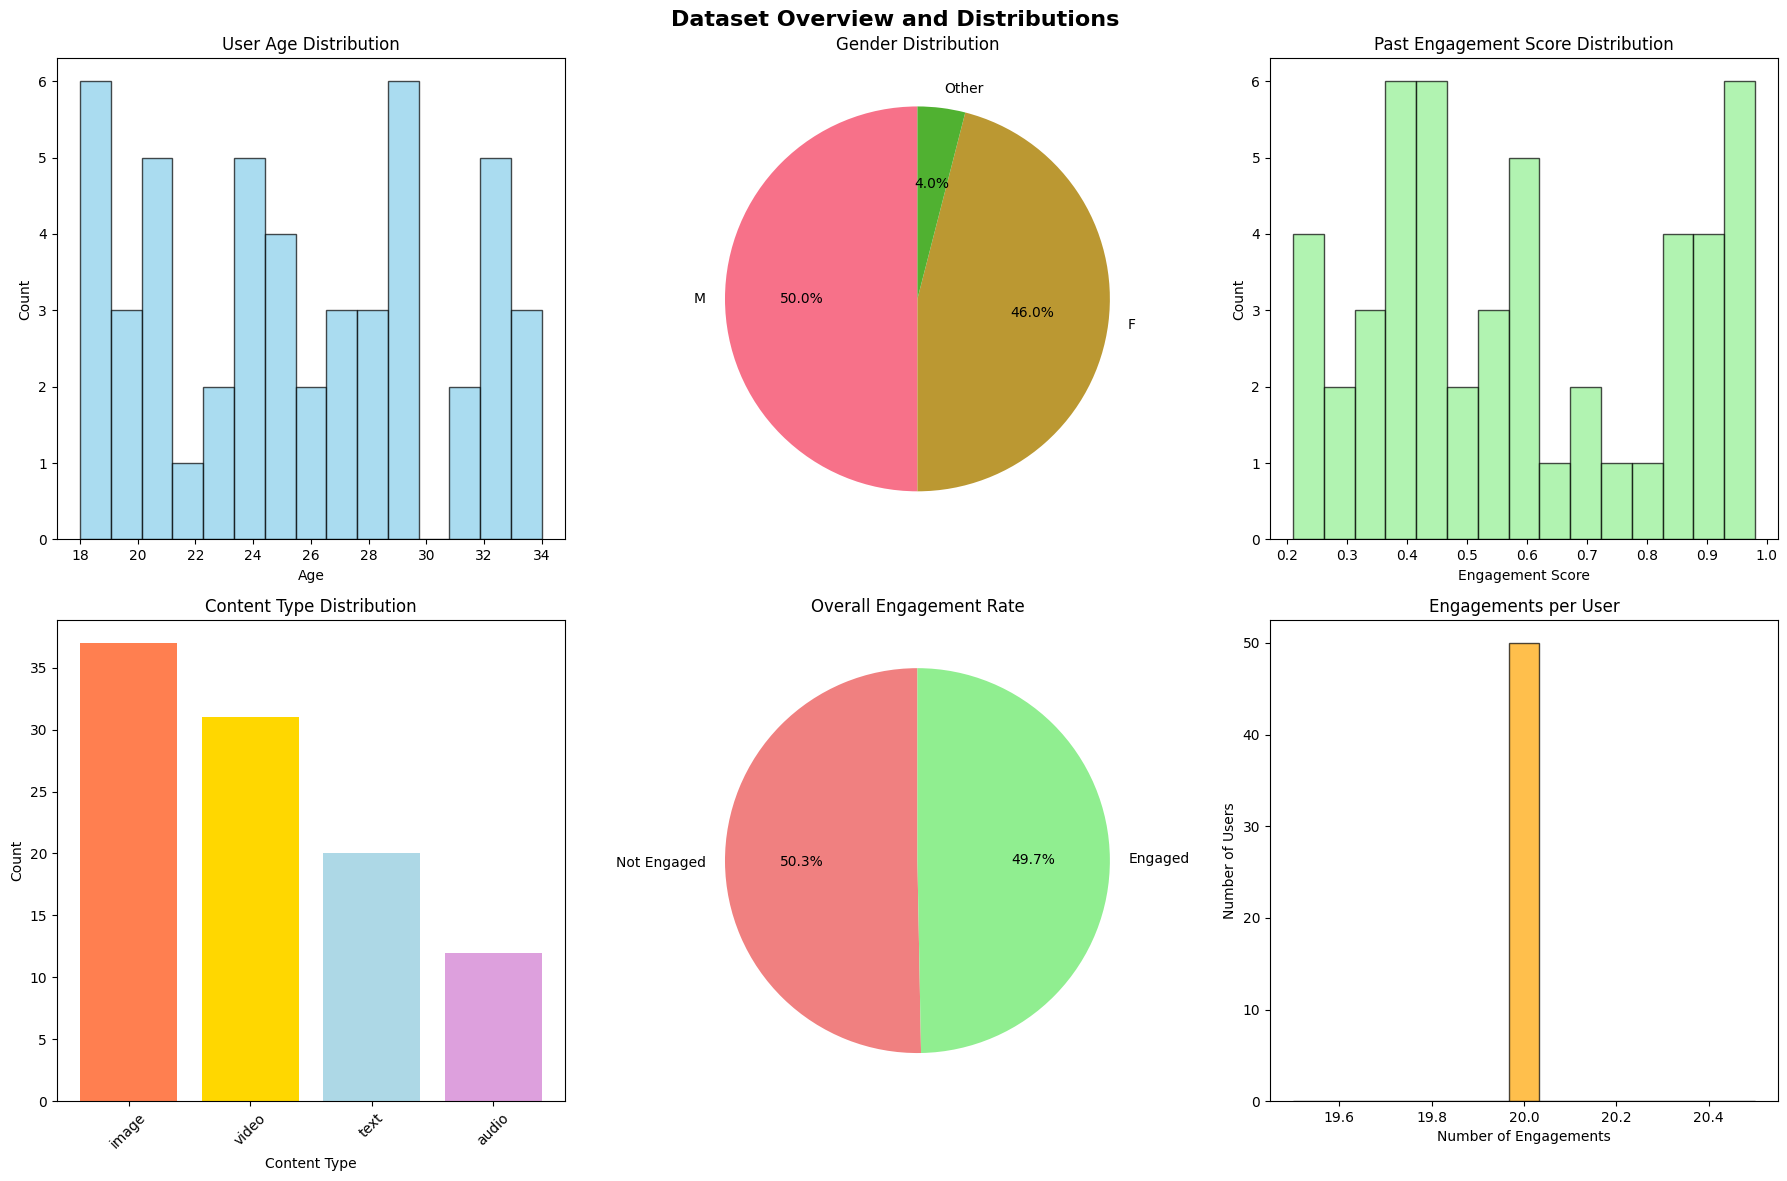

📈 Data exploration visualizations created successfully


In [13]:
# Create visualizations for data exploration
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Dataset Overview and Distributions', fontsize=16, fontweight='bold')

# User age distribution
axes[0, 0].hist(users_df['age'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('User Age Distribution')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Count')

# Gender distribution
gender_counts = users_df['gender'].value_counts()
axes[0, 1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Gender Distribution')

# Engagement score distribution
axes[0, 2].hist(users_df['past_engagement_score'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Past Engagement Score Distribution')
axes[0, 2].set_xlabel('Engagement Score')
axes[0, 2].set_ylabel('Count')

# Content type distribution
content_counts = posts_df['content_type'].value_counts()
axes[1, 0].bar(content_counts.index, content_counts.values, color=['coral', 'gold', 'lightblue', 'plum'])
axes[1, 0].set_title('Content Type Distribution')
axes[1, 0].set_xlabel('Content Type')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Engagement rate
engagement_rate = engagements_df['engagement'].value_counts()
axes[1, 1].pie(engagement_rate.values, labels=['Not Engaged', 'Engaged'], autopct='%1.1f%%',
               colors=['lightcoral', 'lightgreen'], startangle=90)
axes[1, 1].set_title('Overall Engagement Rate')

# Engagements per user
user_engagement_counts = engagements_df['user_id'].value_counts()
axes[1, 2].hist(user_engagement_counts.values, bins=15, alpha=0.7, color='orange', edgecolor='black')
axes[1, 2].set_title('Engagements per User')
axes[1, 2].set_xlabel('Number of Engagements')
axes[1, 2].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

print("📈 Data exploration visualizations created successfully")

## Data preprocessing and feature engineering

### Subtask:
Clean and prepare the data for modeling. This includes handling missing values, encoding categorical features, and creating relevant features from the existing data (e.g., extracting interests from 'top_3_interests', processing tags, and potentially creating interaction features).


**Reasoning**:
Inspect the dataframes for missing values based on the previous validation step and handle them if necessary. The previous validation step reported warnings about missing values in `users_df`, `posts_df`, and `engagements_df`.



In [14]:
print("Missing values in users_df before handling:")
print(users_df.isnull().sum())

print("\nMissing values in posts_df before handling:")
print(posts_df.isnull().sum())

print("\nMissing values in engagements_df before handling:")
print(engagements_df.isnull().sum())

print("\nNo missing values found in the loaded dataframes. Proceeding to feature engineering.")

Missing values in users_df before handling:
user_id                  0
age                      0
gender                   0
top_3_interests          0
past_engagement_score    0
dtype: int64

Missing values in posts_df before handling:
post_id         0
creator_id      0
content_type    0
tags            0
dtype: int64

Missing values in engagements_df before handling:
user_id       0
post_id       0
engagement    0
dtype: int64

No missing values found in the loaded dataframes. Proceeding to feature engineering.


**Reasoning**:
Extract individual interests from the 'top_3_interests' column in `users_df` and process the 'tags' column in `posts_df` by splitting the comma-separated values into lists. These steps prepare the categorical features for later encoding or feature extraction.



In [15]:
# Extract individual interests from 'top_3_interests' in users_df
users_df['interests_list'] = users_df['top_3_interests'].str.split(', ')

# Process 'tags' column in posts_df
posts_df['tags_list'] = posts_df['tags'].str.split(', ')

print("✅ Interests extracted and tags processed.")
display(users_df.head())
display(posts_df.head())

✅ Interests extracted and tags processed.


,user_id,age,gender,top_3_interests,past_engagement_score,interests_list
0,U1,24,F,"sports, art, gaming",0.61,"[sports, art, gaming]"
1,U2,32,F,"travel, food, fashion",0.93,"[travel, food, fashion]"
2,U3,28,Other,"sports, travel, fashion",0.40,"[sports, travel, fashion]"
3,U4,25,M,"fashion, music, tech",0.53,"[fashion, music, tech]"
4,U5,24,M,"fashion, food, fitness",0.80,"[fashion, food, fitness]"


,post_id,creator_id,content_type,tags,tags_list
0,P1,U44,video,"sports, food","[sports, food]"
1,P2,U26,video,"music, travel","[music, travel]"
2,P3,U32,text,"sports, travel","[sports, travel]"
3,P4,U6,image,"music, gaming","[music, gaming]"
4,P5,U32,image,"food, fashion","[food, fashion]"


In [16]:
# Aggregate positive engagements per user
user_positive_engagements = engagements_df[engagements_df['engagement'] == 1].groupby('user_id').size().reset_index(name='positive_engagements_count')
users_df = pd.merge(users_df, user_positive_engagements, on='user_id', how='left').fillna(0)

post_positive_engagements = engagements_df[engagements_df['engagement'] == 1].groupby('post_id').size().reset_index(name='positive_engagements_count')
posts_df = pd.merge(posts_df, post_positive_engagements, on='post_id', how='left').fillna(0)

print("✅ Interaction features (positive engagement counts) added to user and post dataframes.")
display(users_df.head())
display(posts_df.head())

✅ Interaction features (positive engagement counts) added to user and post dataframes.


,user_id,age,gender,top_3_interests,past_engagement_score,interests_list,positive_engagements_count
0,U1,24,F,"sports, art, gaming",0.61,"[sports, art, gaming]",11
1,U2,32,F,"travel, food, fashion",0.93,"[travel, food, fashion]",7
2,U3,28,Other,"sports, travel, fashion",0.40,"[sports, travel, fashion]",9
3,U4,25,M,"fashion, music, tech",0.53,"[fashion, music, tech]",11
4,U5,24,M,"fashion, food, fitness",0.80,"[fashion, food, fitness]",8


,post_id,creator_id,content_type,tags,tags_list,positive_engagements_count
0,P1,U44,video,"sports, food","[sports, food]",12.0
1,P2,U26,video,"music, travel","[music, travel]",2.0
2,P3,U32,text,"sports, travel","[sports, travel]",4.0
3,P4,U6,image,"music, gaming","[music, gaming]",6.0
4,P5,U32,image,"food, fashion","[food, fashion]",9.0


## Content-based filtering

### Subtask:
Build a content-based recommendation component using post attributes like tags and content type. This will involve creating a representation of the posts (e.g., using TF-IDF on tags) and calculating similarity between them.


**Reasoning**:
Combine the tags into a single string for TF-IDF vectorization, initialize the TF-IDF vectorizer, fit and transform the post tags, and then compute the cosine similarity matrix.



In [17]:
# 1. Create a combined string of tags for each post
# Handle potential missing or empty lists by joining with a space, resulting in an empty string if the list is empty or None
posts_df['tags_combined'] = posts_df['tags_list'].apply(lambda x: ' '.join(x) if isinstance(x, list) and x else '')

# 2. Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# 3. Fit the TfidfVectorizer on the combined tag strings and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(posts_df['tags_combined'])

# 4. Calculate the cosine similarity between the TF-IDF vectors of all posts
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("✅ TF-IDF vectorization and cosine similarity calculation completed.")
print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")
print(f"Shape of Cosine Similarity matrix: {cosine_sim_matrix.shape}")

✅ TF-IDF vectorization and cosine similarity calculation completed.
Shape of TF-IDF matrix: (100, 10)
Shape of Cosine Similarity matrix: (100, 100)


In [18]:
# Create a pivot table with users as index, posts as columns, and engagement as values
user_item_matrix_dense = engagements_df.pivot(index='user_id', columns='post_id', values='engagement').fillna(0)

# Convert the dense matrix to a sparse CSR matrix
user_item_matrix_sparse = csr_matrix(user_item_matrix_dense.values)

print("✅ User-item interaction matrix created and converted to sparse format.")
print(f"Shape of dense user-item matrix: {user_item_matrix_dense.shape}")
print(f"Shape of sparse user-item matrix: {user_item_matrix_sparse.shape}")

✅ User-item interaction matrix created and converted to sparse format.
Shape of dense user-item matrix: (50, 100)
Shape of sparse user-item matrix: (50, 100)


## Hybrid recommendation system

### Subtask:
Combine the content-based and collaborative filtering approaches to leverage the strengths of both methods and improve recommendation accuracy.


**Reasoning**:
Define the function to combine collaborative and content-based filtering scores using a weighted sum. This involves accessing the user's historical engagement, calculating collaborative scores, calculating content-based scores based on engaged posts, and combining them based on the provided weight.



In [19]:
def get_hybrid_scores(user_id: str, user_item_matrix: pd.DataFrame, post_sim_matrix: np.ndarray, posts_df: pd.DataFrame, cf_weight: float = 0.5) -> pd.Series:

    if user_id not in user_item_matrix.index:
        logger.warning(f"User ID {user_id} not found in the user-item matrix.")
        return pd.Series(0, index=posts_df['post_id'])


    user_engagement = user_item_matrix.loc[user_id].values.reshape(1, -1) # Reshape for matrix multiplication


    cf_scores = np.dot(user_engagement, post_sim_matrix).flatten()

    engaged_post_indices = user_item_matrix.columns[user_engagement.flatten() > 0]
    if engaged_post_indices.empty:
        cb_scores = np.zeros_like(cf_scores) # No engaged posts, no content-based score
        logger.info(f"User {user_id} has no positive engagements, content-based scores are zero.")
    else:
        engaged_indices_in_sim_matrix = posts_df[posts_df['post_id'].isin(engaged_post_indices)].index.tolist()
        cb_scores = post_sim_matrix[:, engaged_indices_in_sim_matrix].sum(axis=1)


    cf_scores_normalized = cf_scores / (cf_scores.max() if cf_scores.max() > 0 else 1e-6)
    cb_scores_normalized = cb_scores / (cb_scores.max() if cb_scores.max() > 0 else 1e-6)


    # 5. Combine the collaborative and content-based scores using a weighted sum
    combined_scores = (cf_weight * cf_scores_normalized) + ((1 - cf_weight) * cb_scores_normalized)

    # 6. Return the combined scores for all posts
    return pd.Series(combined_scores, index=posts_df['post_id'])

print("✅ Hybrid score calculation function defined.")

✅ Hybrid score calculation function defined.


**Reasoning**:
Test the `get_hybrid_scores` function with a sample user and display the resulting scores to verify its functionality.



In [20]:
# Example usage: Get hybrid scores for the first user (U1)
sample_user_id = users_df['user_id'].iloc[0]
hybrid_scores = get_hybrid_scores(sample_user_id, user_item_matrix_dense, cosine_sim_matrix, posts_df, cf_weight=0.7)

print(f"Hybrid scores for user {sample_user_id}:")
# Display the top 10 posts by hybrid score for the sample user
display(hybrid_scores.sort_values(ascending=False).head(10))

Hybrid scores for user U1:


,0
post_id,
P57,0.907180
P48,0.907180
P23,0.874210
P31,0.743322
P79,0.743322
P88,0.743322
P32,0.743322
P90,0.743322
P27,0.743322


## Generate recommendations

### Subtask:
Generate the top 3 post recommendations for each user based on the calculated hybrid scores.


**Reasoning**:
Generate recommendations for each user based on the calculated hybrid scores and store them.



In [23]:
# 1. Initialize a dictionary to store recommendations
recommendations = {}

# 2. Iterate through each user_id in the users_df
for user_id in users_df['user_id']:
    # 3. Get hybrid scores for the current user
    # Use cf_weight = 0.7 as specified in the instructions
    user_hybrid_scores = get_hybrid_scores(user_id, user_item_matrix_dense, cosine_sim_matrix, posts_df, cf_weight=0.7)

    # 4. Sort the scores in descending order and select the top 3 post_ids
    top_3_posts = user_hybrid_scores.sort_values(ascending=False).head(3).index.tolist()

    # 5. Store the user_id and their top 3 recommended post_ids
    recommendations[user_id] = top_3_posts

# 6. Present the recommendations
print("✅ Top 3 Post Recommendations for Each User:")
for user_id, recommended_posts in recommendations.items():
    print(f"User {user_id}: {recommended_posts}")


✅ Top 3 Post Recommendations for Each User:
User U1: ['P57', 'P48', 'P23']
User U2: ['P5', 'P69', 'P17']
User U3: ['P26', 'P35', 'P7']
User U4: ['P3', 'P34', 'P97']
User U5: ['P22', 'P78', 'P48']
User U6: ['P57', 'P48', 'P1']
User U7: ['P71', 'P76', 'P36']
User U8: ['P4', 'P99', 'P33']
User U9: ['P56', 'P30', 'P52']
User U10: ['P1', 'P17', 'P58']
User U11: ['P57', 'P48', 'P23']
User U12: ['P70', 'P92', 'P5']
User U13: ['P23', 'P14', 'P54']
User U14: ['P1', 'P17', 'P58']
User U15: ['P14', 'P63', 'P54']
User U16: ['P30', 'P29', 'P60']
User U17: ['P36', 'P11', 'P77']
User U18: ['P3', 'P34', 'P97']
User U19: ['P23', 'P76', 'P71']
User U20: ['P37', 'P43', 'P49']
User U21: ['P2', 'P76', 'P71']
User U22: ['P14', 'P63', 'P54']
User U23: ['P1', 'P17', 'P58']
User U24: ['P36', 'P11', 'P77']
User U25: ['P56', 'P30', 'P52']
User U26: ['P81', 'P40', 'P72']
User U27: ['P57', 'P48', 'P30']
User U28: ['P56', 'P1', 'P46']
User U29: ['P14', 'P63', 'P54']
User U30: ['P31', 'P27', 'P32']
User U31: ['P30',

In [24]:
def calculate_mean_average_precision(recommendations: Dict[str, List[str]], engagements_df: pd.DataFrame) -> float:

    # Create a set of relevant posts for each user from the engagements_df (ground truth)
    relevant_engagements = engagements_df[engagements_df['engagement'] == 1]
    user_relevant_posts = relevant_engagements.groupby('user_id')['post_id'].apply(set).to_dict()

    total_average_precision = 0
    num_users_with_relevant_items = 0

    for user_id, recommended_posts in recommendations.items():
        # Ensure the user has relevant posts in the ground truth
        if user_id in user_relevant_posts and user_relevant_posts[user_id]:
            num_users_with_relevant_items += 1
            relevant_posts = user_relevant_posts[user_id]
            num_relevant_items = len(relevant_posts)

            # Calculate Average Precision (AP) for the current user
            sum_precision = 0
            num_hits = 0
            for i, post_id in enumerate(recommended_posts):
                if post_id in relevant_posts:
                    num_hits += 1
                    precision_at_i = num_hits / (i + 1)
                    sum_precision += precision_at_i

            # Avoid division by zero if there are no relevant items for the user (already handled by the if condition)
            average_precision = sum_precision / num_relevant_items if num_relevant_items > 0 else 0
            total_average_precision += average_precision

    # Calculate Mean Average Precision (MAP)
    map_score = total_average_precision / num_users_with_relevant_items if num_users_with_relevant_items > 0 else 0

    return map_score

# Calculate MAP using the generated recommendations
map_score = calculate_mean_average_precision(recommendations, engagements_df)

print(f"Mean Average Precision (MAP): {map_score:.4f}")

Mean Average Precision (MAP): 0.0370


In [29]:
def calculate_precision_recall_at_k(recommendations: Dict[str, List[str]], engagements_df: pd.DataFrame, k: int = 3) -> Tuple[float, float]:

    relevant_engagements = engagements_df[engagements_df['engagement'] == 1]
    user_relevant_posts = relevant_engagements.groupby('user_id')['post_id'].apply(set).to_dict()

    total_precision = 0
    total_recall = 0
    num_users = 0

    for user_id, recommended_posts in recommendations.items():
        if user_id in user_relevant_posts and user_relevant_posts[user_id]:
            num_users += 1
            relevant_posts = user_relevant_posts[user_id]
            top_k_recommendations = set(recommended_posts[:k])

            hits = top_k_recommendations.intersection(relevant_posts)
            num_hits = len(hits)

            precision_at_k = num_hits / k if k > 0 else 0
            total_precision += precision_at_k

            # Avoid division by zero if a user has no relevant items (should be handled by the if condition above, but for safety)
            recall_at_k = num_hits / len(relevant_posts) if relevant_posts else 0
            total_recall += recall_at_k

    avg_precision_at_k = total_precision / num_users if num_users > 0 else 0
    avg_recall_at_k = total_recall / num_users if num_users > 0 else 0

    return avg_precision_at_k, avg_recall_at_k

precision_at_3, recall_at_3 = calculate_precision_recall_at_k(recommendations, engagements_df, k=3)

print(f"Average Precision@{3}: {precision_at_3:.4f}")
print(f"Average Recall@{3}: {recall_at_3:.4f}")

Average Precision@3: 0.1733
Average Recall@3: 0.0511


### Subtask:
Combine the tags into a single string for TF-IDF vectorization, initialize the TF-IDF vectorizer, fit and transform the post tags, and then compute the cosine similarity matrix.

In [25]:
# 1. Create a combined string of tags for each post
# Handle potential missing or empty lists by joining with a space, resulting in an empty string if the list is empty or None
posts_df['tags_combined'] = posts_df['tags_list'].apply(lambda x: ' '.join(x) if isinstance(x, list) and x else '')

# 2. Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# 3. Fit the TfidfVectorizer on the combined tag strings and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(posts_df['tags_combined'])

# 4. Calculate the cosine similarity between the TF-IDF vectors of all posts
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("✅ TF-IDF vectorization and cosine similarity calculation completed.")
print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")
print(f"Shape of Cosine Similarity matrix: {cosine_sim_matrix.shape}")

✅ TF-IDF vectorization and cosine similarity calculation completed.
Shape of TF-IDF matrix: (100, 10)
Shape of Cosine Similarity matrix: (100, 100)


## Collaborative filtering

### Subtask:
Develop a collaborative filtering component based on user-post engagement data. This can be achieved using techniques like matrix factorization or neighborhood-based methods.

**Reasoning**:
Create a user-item interaction matrix from the engagements data and convert it to a sparse format for efficient processing.

In [26]:
# Create a pivot table with users as index, posts as columns, and engagement as values
user_item_matrix_dense = engagements_df.pivot(index='user_id', columns='post_id', values='engagement').fillna(0)

# Convert the dense matrix to a sparse CSR matrix
user_item_matrix_sparse = csr_matrix(user_item_matrix_dense.values)

print("✅ User-item interaction matrix created and converted to sparse format.")
print(f"Shape of dense user-item matrix: {user_item_matrix_dense.shape}")
print(f"Shape of sparse user-item matrix: {user_item_matrix_sparse.shape}")

✅ User-item interaction matrix created and converted to sparse format.
Shape of dense user-item matrix: (50, 100)
Shape of sparse user-item matrix: (50, 100)


In [27]:

print("Chosen Evaluation Metrics:")
print("- Precision@k: Measures the accuracy of the top-k recommendations.")
print("- Recall@k: Measures how many relevant items are captured in the top-k recommendations.")
print("- Mean Average Precision (MAP): Considers the ranking of relevant items.")

# 2. Explain why these metrics are appropriate
print("\nWhy these metrics are appropriate:")
print("Precision@k and Recall@k directly evaluate the quality of the ranked list at a specific cutoff 'k'.")
print("In a recommendation system, users typically only look at the first few recommendations,")
print("so evaluating the top-k items is crucial.")
print("Precision@k tells us how 'pure' our top-k list is (what percentage is good).")
print("Recall@k tells us how many of the potentially good items we managed to surface in the top-k.")
print("MAP is important because the order matters in recommendations. A relevant item ranked higher is better.")
print("MAP averages the Precision at each point where a relevant item is found, for each user, and then averages across users.")

# 3. Describe how to calculate these metrics
print("\nHow to calculate these metrics:")
print("Ground Truth: Relevant items for a user are defined as the posts the user positively engaged with (engagement == 1) in the engagements_df.")

print("\nCalculation steps:")
print("For each user:")
print("  - Get the list of recommended posts (Top N, e.g., N=3).")
print("  - Get the list of posts the user actually engaged with positively (ground truth).")
print("  - Precision@k: (Number of recommended items in the top-k that are in the ground truth) / k")
print("  - Recall@k: (Number of recommended items in the top-k that are in the ground truth) / (Total number of relevant items for the user)")
print("  - Average Precision (AP): For each relevant item in the ground truth that is found in the recommended list, calculate the Precision at that rank.")
print("    Sum these Precision values and divide by the total number of relevant items for the user.")
print("MAP: Average the Average Precision scores across all users.")

# 4. Outline challenges and considerations
print("\nChallenges and Considerations:")
print("- Data Sparsity: The engagement data is likely sparse (users only engage with a small fraction of all posts).")
print("  This makes it challenging to define a comprehensive ground truth for all users and to calculate Recall accurately,")
print("  especially if a user has very few positive engagements.")
print("- Definition of 'Positive' Engagement: We are currently using engagement==1. In a real system, different engagement types (like, share, comment, view duration) could have different weights or be used to define relevance differently.")
print("- Cold Start Problem: New users or new posts with no engagement data will be difficult to evaluate using engagement-based metrics.")
print("- Implicit vs. Explicit Feedback: We are using implicit feedback (engagement). Explicit feedback (ratings) would provide a clearer signal of user preference but is often not available.")
print("- Evaluation Metric Choice Depends on Goal: If the goal is to ensure users see *some* relevant items (exploration), Recall might be more important. If the goal is to ensure the *very first* recommendations are highly relevant (exploitation), Precision or MAP might be prioritized.")

print("✅ Evaluation metrics defined and explained.")

Chosen Evaluation Metrics:
- Precision@k: Measures the accuracy of the top-k recommendations.
- Recall@k: Measures how many relevant items are captured in the top-k recommendations.
- Mean Average Precision (MAP): Considers the ranking of relevant items.

Why these metrics are appropriate:
Precision@k and Recall@k directly evaluate the quality of the ranked list at a specific cutoff 'k'.
In a recommendation system, users typically only look at the first few recommendations,
so evaluating the top-k items is crucial.
Precision@k tells us how 'pure' our top-k list is (what percentage is good).
Recall@k tells us how many of the potentially good items we managed to surface in the top-k.
MAP is important because the order matters in recommendations. A relevant item ranked higher is better.
MAP averages the Precision at each point where a relevant item is found, for each user, and then averages across users.

How to calculate these metrics:
Ground Truth: Relevant items for a user are defined 